In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from nilearn.connectome import sym_matrix_to_vec
from scipy.stats import pearsonr
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from cmath import isinf
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import multiprocessing
from sklearn.model_selection import KFold

from skorch import NeuralNet
from skorch.callbacks import Callback
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def loader_to_numpy(loader):
    features, targets = [], []
    for feat, targ in loader:
        features.append(feat.numpy())
        targets.append(targ.numpy())
    return np.concatenate(features), np.concatenate(targets)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim_feat = 499500, input_dim_target = 1, hidden_dim_feat = 1000, output_dim = 2, dropout_rate = 0):
        super(MLP, self).__init__()
        
        # Xavier initialization for feature MLP
        self.feat_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_feat),
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        self.init_weights(self.feat_mlp)

        # Xavier initialization for target MLP
        self.target_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_target),
            nn.Linear(input_dim_target, output_dim)
        )
        self.init_weights(self.target_mlp)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x, y):
        features = self.feat_mlp(x)
        targets = self.target_mlp(y)
        features = nn.functional.normalize(features, p=2, dim=1)
        targets = nn.functional.normalize(targets, p=2, dim=1)
        return features, targets

In [5]:
class AgeEstimator(BaseEstimator):
    """ Define the age estimator on latent space network features.
    """
    def __init__(self):
        n_jobs = multiprocessing.cpu_count()
        self.age_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10.**np.arange(-2, 3)}, cv=5,
            scoring="r2", n_jobs=n_jobs)

    def fit(self, X, y):
        self.age_estimator.fit(X, y)
        return self.score(X, y), self.r2(X, y)

    def predict(self, X):
        y_pred = self.age_estimator.predict(X)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return mean_absolute_percentage_error(y, y_pred)
    
    def r2(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return r2_score(y, y_pred)

In [52]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, target_name, indices, transform = None, regions = None, threshold_mat = False, threshold_percent = None, random_state=42):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        
        features = np.load(path_feat)[indices]
        participant_data = pd.read_csv(path_target)
        targets = participant_data[target_name].values[indices]
        targets = np.expand_dims(targets, axis = 1)
        
        if threshold_mat:
            thresholded_feat = []
            for matrix in features:
                threshold = np.percentile(matrix, threshold_percent)
                matrix[matrix < threshold] = 0
                thresholded_feat.append(matrix)
            threshold_feat = np.stack(thresholded_feat)
            features = threshold_feat
        

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        
        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        self.n_features = vectorized_feat.shape[-1]
        
        if transform is not None:
            # augmentation only in training mode
            if transform != "copy":
                augmented_features = np.array([self.transform(sample, regions = regions) for sample in features])

                self.n_views = self.n_views + augmented_features.shape[1]
                self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
                for sub in range(self.n_sub):
                    self.features[sub, 0, :] = vectorized_feat[sub]
                    self.features[sub, 1:, :] = augmented_features[sub]
            else:
                self.features = np.repeat(np.expand_dims(vectorized_feat, axis = 1), 2, axis=1)
        else:
            self.features = np.expand_dims(vectorized_feat, axis = 1)
            
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.from_numpy(targets).float()
        
        return features, targets

In [9]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

def rbf(x, krnl_sigma):
        x = x - x.T
        return torch.exp(-(x**2)/(2*(krnl_sigma**2)))

In [10]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str='expw', temperature: float=0.03, contrast_mode: str='all',
                 base_temperature: float=0.07, krnl_sigma: float = 1., kernel: callable=cauchy, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.krnl_sigma = krnl_sigma
        self.delta_reduction = delta_reduction

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        contrast_count = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, krnl_sigma = self.krnl_sigma)     
        
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*anchor_count, device=device).view(-1, 1),
            0
        )
        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))


        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()

In [11]:
from torch.utils.data import ConcatDataset

train_dataset = MatData("matrices.npy", "participants.csv", "age", train=True, train_size = 100, test_size = 50)
test_dataset = MatData("matrices.npy", "participants.csv", "age", train=False, train_size = 100, test_size = 50)
dataset = ConcatDataset([train_dataset, test_dataset])

dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle = False)
X, y = loader_to_numpy(dataloader)
X = X.squeeze(1)

X_train, y_train = X[:100], y[:100]
X_test, y_test = X[100:], y[100:]


In [12]:
test_dataset = Dataset(X_test, y_test)

In [56]:
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [12]:
participants = pd.read_csv("participants.csv")

In [ ]:
def train(model, train_loader, criterion_pft, criterion_ptt, optimizer):
    
    model.train()
    for batch_num, (features, targets) in enumerate(train_loader):
        bsz = targets.shape[0]
        n_views = features.shape[1]
        n_feat = features.shape[-1]
        
        features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
        features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]
        
        optimizer.zero_grad()
        out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0)) # ([bsz*5, 1], [bsz*5, 1])
        
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]
        
        loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])
        
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]
        loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])
    
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        batch_losses.append(loss.item())
        optimizer.step()
        
        return batch_losses


In [94]:
def test(model, data_loader, criterion_pft, criterion_ptt, optimizer):
    
    model.eval()
    test_losses = []
    emb_features = [] # saving the embedded features for each batch
    emb_targets = []
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        for batch_num, (features, targets) in enumerate(v):
            bsz = targets.shape[0]
            n_views = 1
            n_feat = features.shape[-1]

            if len(features.shape) > 2:
                n_views = features.shape[1]
                features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
            features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]

            out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0))   

            out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
            out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]

            loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])

            out_target = torch.split(out_target, [bsz]*n_views, dim=0)
            out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]

            loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
            loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])

            emb_features.append(out_feat[:, 0, :])
            emb_targets.append(out_target[:, 0, :])

            test_losses.append(loss.item())
            total_loss += loss.item() * features.size(0)
            total_samples += features.size(0)

        test_losses =np.array(test_losses)
        average_loss = total_loss / total_samples
        print('Mean Test Loss: %6.2f' % (average_loss))
        
        return torch.row_stack(emb_features).cpu(), torch.row_stack(emb_features).cpu()
    

In [93]:
k = 2
# val_indices = participants.index[participants['dataset'] == "COBRE"].values
n_subj = len(participants)
batch_size = 30

input_dim_feat = 499500 # vectorized mat, diagonal discarded
# the rest is arbitrary
hidden_dim_feat = 1000
input_dim_target = 1
output_dim = 2

lr = 0.01
dropout_rate = 0
weight_decay = 0
kernel = cauchy
epochs = 100

criterion_pft = KernelizedSupCon(method='expw', temperature=0.03, base_temperature=0.07, kernel=kernel, krnl_sigma = 1, contrast_mode = 'all')
criterion_ptt = KernelizedSupCon(method='expw', temperature=0.03, base_temperature=0.07, kernel=kernel, krnl_sigma = 1, contrast_mode = 'all')

for train_size in train_sizes:
    print(train_size)
    all_indices = np.arange(n_subj)
    val_size = 1 - train_size
    np.random.shuffle(all_indices)
    
    val_size = int(n_subj * val_size)
    print(val_size)
    
    val_indices = np.random.choice(all_indices, val_size, replace = False)
    cv_indices = all_indices[~np.isin(all_indices, val_indices)]
    print(len(cv_indices))
    
    validation_dataset = MatData("matrices.npy", "participants.csv", "age", indices = val_indices)
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    
    folds = np.array_split(cv_indices, k)
    
    for i in range(k):
        test_indices = folds[i]
        train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
        
        train_dataset = MatData("matrices.npy", "participants.csv", "age", indices = train_indices)
        test_dataset = MatData("matrices.npy", "participants.csv", "age", indices = test_indices)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # already shuffled
        val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, output_dim, dropout_rate).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
        
        for epoch in epochs:
            batch_losses = train(model, train_loader, criterion_pft, criterion_ptt, optimizer)
            print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')
        
        X_train, y_train = gather_feats_targets(model, train_loader, device)
        estimator = AgeEstimator().fit(X_train, y_train)
        mae_train = age_estimator.score(X_train, y_train)
        r2_train = age_estimator.r2(X_train, y_train)
        
        
        
        
        
        
    
    
    

    
    

0.1
842
94


KeyboardInterrupt: 

In [46]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    X=X,  # Combined features
    y=y,
    cv = 5,
    scoring='r2',
    verbose = 2
)

make_scorer(r2_score)
[learning_curve] Training set sizes: [ 12  24  36  48  60  72  84  96 108]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   3.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   3.6s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.7min finished


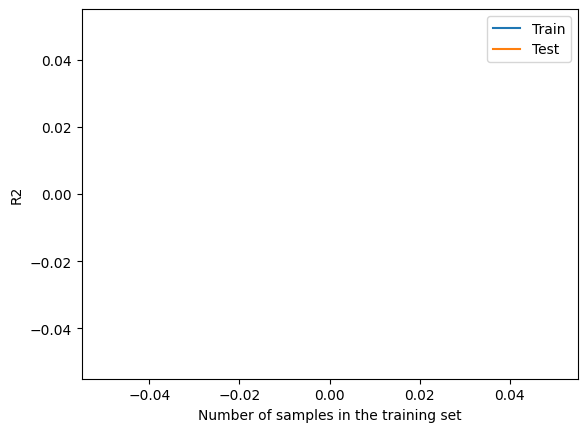

In [31]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="R2")
display.plot()
plt.show()

In [39]:
train_scores

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])